## Main Program for classification

# imports

In [28]:
# imports

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
from shapely.geometry import Polygon, box
from shapely.affinity import scale, affine_transform
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import time
from sklearn.metrics import confusion_matrix

In [29]:
# Function to plot image with given polygons:
def plot_picture_with_polygons(image, polygons):
    fig, ax = plt.subplots(1, figsize=(20,12))
    ax.imshow(image)
    for polygon in polygons:
        points = polygon
        polygon = patches.Polygon(points, closed=True, edgecolor='red', fill=False, linewidth=2, label=label)
        ax.add_patch(polygon)
    plt.show()

# Function to resize the image and its polygons:
def resize_image_and_poylgons(image, defects, upper_pixel_size=1000):

    # Calculate the new widht, heights and the scale factor:
    height, width = image.shape[:2]
    scale_factor = (upper_pixel_size / max(width, height)) if max(width, height) > upper_pixel_size else 1
    new_width, new_height = int(width * scale_factor), int(height * scale_factor)

    # Resize the image:
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # Rescale the defect polygon coordinates:
    rescaled_defects = defects.copy()
    for defect in rescaled_defects:
        defect["points"] = [[x * scale_factor, y * scale_factor] for [x, y] in defect["points"]]

    return resized_image, rescaled_defects

## Functions to filter images

In [30]:
#function to find rough areas in picture
def rough_image_filter(image, threshold=8):

    #read in image as greyscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #apply local binary pattern
    lbp = local_binary_pattern(image, P=8, R=2, method='uniform')

    lbp_uint8 = np.uint8((lbp / lbp.max())*255)
    
    blurred = cv2.blur(lbp_uint8, (5, 5), 0)
    mean = np.mean(blurred)
    std = np.std(blurred)
    median = np.median(blurred)
    #apply thresholding
    _, binary_image = cv2.threshold(blurred, mean - std, 255, cv2.THRESH_BINARY) 

    binary_blurred = cv2.blur(binary_image, (50, 50), 0)
    mean = np.mean(binary_blurred)
    std = np.std(binary_blurred)
    #apply thresholding
    _, binary_image = cv2.threshold(binary_blurred, mean - 1.5 * std, 255, cv2.THRESH_BINARY) # normlaize and convert to uint8, then blur
    
    return lbp, binary_image

In [31]:
# Function to detect color values in an image:
def color_detector(image, lower_bounds: list, upper_bounds: list) -> list:
        
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        mask = np.zeros(hsv_image.shape[:2], dtype=np.uint8)
        for lower_bound, upper_bound in zip(lower_bounds, upper_bounds):
            lower_bound = np.array(lower_bound)
            upper_bound = np.array(upper_bound)
            temp_mask = cv2.inRange(hsv_image, lower_bound, upper_bound)
            mask = cv2.bitwise_or(mask, temp_mask)
        return mask

# Function to identify reddish areas in an image: 
def reddish_image_filter(image):

    rusty_lower_bounds = [[0, 40, 50]]
    rusty_upper_bounds = [[20, 255, 200]]
    reddish_areas = color_detector(image, rusty_lower_bounds, rusty_upper_bounds)

    return reddish_areas

# Function to identify metallic areas in an image:
def metallic_image_filter(image):
     
    metallic_lower_bounds = [[90, 5, 120], [20, 10, 150]]
    metallic_upper_bounds = [[120, 60, 240], [130, 60, 220]]
    metallic_areas = color_detector(image, metallic_lower_bounds, metallic_upper_bounds)

    return metallic_areas

# Function to identify colorful areas in an image:
def colorful_image_filter(image):
     
    colorful_lower_bounds = [[0, 60, 50]]
    colorful_upper_bounds = [[180, 255, 255]]
    colorful_areas = color_detector(image, colorful_lower_bounds, colorful_upper_bounds)

    return colorful_areas

# Function to identify black areas in an image:
def black_image_filter(image):
     
    black_lower_bounds = [[0, 0, 0]]
    black_upper_bounds = [[180, 255, 50]]
    black_areas = color_detector(image, black_lower_bounds, black_upper_bounds)

    return black_areas

# Function to create a color bin image filter: 
def color_bins_image_filter(image, bin_size=20):

     # Create a color bin mask:
    color_bin_mask = np.zeros(image.shape[:2], dtype=np.uint8)

    # Create binary color masks for each color space bin:
    for i in range(0, 180, bin_size):
        color_bin_lower_bounds = [[i, 0, 0]]
        color_bin_upper_bounds = [[i + bin_size if i == 180 - bin_size else i + bin_size - 1, 255, 255]]
        color_bin_areas = color_detector(image, color_bin_lower_bounds, color_bin_upper_bounds)
        color_bin_mask[color_bin_areas > 0] = (i // bin_size) + 1

    return color_bin_mask



In [32]:
#find darker areas in an image
def darker_image_filter(image, z = 200):
    # Convert image to grayscale:
    grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grey_image = cv2.blur(grey_image, (15, 15), 0)
    mean = np.mean(grey_image)
    std = np.std(grey_image) / 250
    dark_areas = (grey_image < mean - z * std)
    dark_areas = dark_areas.astype(np.uint8)
    blurred = cv2.blur(dark_areas, (5, 5), 0) *255
    return blurred

In [33]:
#legthy image filter
def lengthy_image_filter(image, ratio = 2.5):
# Blur image:
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.GaussianBlur(gray_image, (7, 7), 0)

    # Apply edge detector:
    edges = cv2.Canny(gray_image, 50, 150)

    # Apply morphological operations 
    kernel = np.ones((15, 15), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)
    edges = cv2.erode(edges, kernel, iterations=1)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    stencil = np.zeros(gray_image.shape).astype(gray_image.dtype)
    color = [255]
    for contour in contours:
        try:
            # Get fitted bounding box
            rect = cv2.minAreaRect(contour)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            width = rect[1][0]
            height = rect[1][1]
            
            # Calculate aspect ratio
            aspect_ratio = float(max(width, height)) / min(width, height)
            if aspect_ratio > 2.5:
                cv2.drawContours(stencil, [box], 0, (0, 0, 255), 2)
                cv2.fillPoly(stencil, [box], color)
        except:
            pass
    return stencil

In [34]:
# Function to get an image with edges for the lengthy objects filter:
def lengthy_image_filter_edges(image):
    
    # Read in image as greyscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Blur image:
    blurred_image = cv2.GaussianBlur(gray_image, (7, 7), 0)

    # Apply edge detector:
    edges = cv2.Canny(blurred_image, 50, 150)

    # Apply morphological operations 
    kernel = np.ones((15, 15), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)
    edges = cv2.erode(edges, kernel, iterations=1)

    return edges

# Function to get number of contours with aspect ratio > 2:
def extract_lengthy_features_1(edges, defect_polygon):

    # Create defect polygon and calculate its width and height:
    defect_polygon = Polygon(defect_polygon)
    defect_rect_coords = np.array(list(defect_polygon.minimum_rotated_rectangle.exterior.coords)[:-1])
    distances = [np.linalg.norm(defect_rect_coords[i] - defect_rect_coords[(i + 1) % len(defect_rect_coords)]) for i in range(len(defect_rect_coords))]
    defect_width, defect_height = sorted(distances)[0], sorted(distances)[-1]

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Extract overlapping contours (where >80% of the contour area is overlapping with the polygon):
    overlapping_contours = []
    for contour in contours: 
        if not np.array_equal(contour[0], contour[-1]):
            contour = np.vstack([contour, contour[0:1]])
        try:
            contour_as_polygon = Polygon([(x, y) for x, y in contour[:, 0]])
            intersection = contour_as_polygon.intersection(defect_polygon)
            intersection_area = intersection.area
        except:
            intersection_area = 0
        contour_area = contour_as_polygon.area
        if intersection_area > 0 and intersection_area >= 0.8 * contour_area:
            overlapping_contours.append(contour)

    # Extract characteristics per overlapping contour:
    characteristics = []
    lengths = []
    for contour in overlapping_contours:

        # Get fitted bounding box
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        width = max(rect[1][0], 1)
        height = max(rect[1][1], 1)
        
        # Calculate aspect ratio
        aspect_ratio = float(max(width, height) / min(width, height))
        characteristics.append(aspect_ratio)
        lengths.append(max(width, height))
    
    # Extract number of contours with aspect ratio >= 2 and the average aspect ratio of these contours:
    number = 0
    avg_aspect_ratio_lengthy = 0
    for aspect_ratio in characteristics:
        if aspect_ratio >= 2.5:
            avg_aspect_ratio_lengthy += aspect_ratio
            number += 1
    avg_aspect_ratio_lengthy = max(avg_aspect_ratio_lengthy / max(number, 1), 1)

    # Extract the quotient (length of the lengthiest contour) / (length of the defect):
    rel_length = (max(lengths) / max(defect_width, defect_height)) if len(lengths) > 0 else 0

    return number, avg_aspect_ratio_lengthy, rel_length


In [35]:
# Function to extract the circles in an image: 
def extract_circles(image):

    # Convert image to greyscale:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Blur image:
    image = cv2.GaussianBlur(image, (5, 5), 2)

    # Detect circles:
    circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, dp=1, minDist=200, param1=100, param2=40, minRadius=10, maxRadius=150)
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")

    return circles

# Function to get a filtered image with the convex hulls of connected edges:
def convex_shape_image_filter(image):

    # Convert image to greyscale:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Blur image:
    image = cv2.GaussianBlur(image, (5, 5), 2)

    # Apply morphological operations: 
    edges = cv2.Canny(image, 50, 150)
    kernel = np.ones((10, 10), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)
    kernel = np.ones((8, 8), np.uint8)
    edges = cv2.erode(edges, kernel, iterations=1)
    
    # Create a mask which fills the convex hulls of connected edges and create a list with all convex hulls:
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(edges, dtype=np.uint8)
    hulls = []
    for contour in contours:
        hull = cv2.convexHull(contour)
        hulls.append(hull)
        cv2.drawContours(mask, [hull], -1, (255), thickness=cv2.FILLED)
    
    # Create a new binary image with the convex hulls:
    filled_edges = cv2.bitwise_or(edges, mask)

    return filled_edges, contours, hulls

In [36]:
def scale_polygon(polygon, scale):
    # Calculate the centroid of the polygon
    centroid = np.mean(polygon, axis=0)
    
    # Scale the polygon coordinates
    scaled_polygon = (polygon - centroid) * scale + centroid
    return scaled_polygon.astype(np.int32)

def calculate_average_darkness(image, mask):
    # Calculate the average darkness in the masked area
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    gray_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    values = gray_image[mask > 0]
    average = np.mean(values)
    return average

def darkness_gradient(image, polygon, scale_outer = 0.85, scale_inner = 0.7):

    # Convert the polygon to np.int32
    original_polygon = np.array(polygon, dtype=np.int32)
    
    # Create a polygon that is 1.1 times the size of the original polygon
    outer_polygon = scale_polygon(original_polygon, scale_outer)
    inner_polygon = scale_polygon(original_polygon, scale_inner)
    
    # Reshape the polygons to the required format
    original_polygon = original_polygon.reshape((-1, 1, 2))
    outer_polygon = outer_polygon.reshape((-1, 1, 2))
    inner_polygon = inner_polygon.reshape((-1, 1, 2))
    
    # Create a mask for the area between the polygons
    mask_outer = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask_outer, [original_polygon], 255)
    cv2.fillPoly(mask_outer, [outer_polygon], 0)

    mask_inner = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask_inner, [outer_polygon], 255)
    cv2.fillPoly(mask_inner, [inner_polygon], 0)
    
    average_darkness_outer = calculate_average_darkness(image, mask_outer)
    average_darkness_inner = calculate_average_darkness(image, mask_inner)

    feature_value = average_darkness_inner / average_darkness_outer
    return feature_value

# functions to evaluate / visualize

In [37]:
def get_overlapping_values(filtered_image, defect_polygon):
    # Generate polygon mask:
    mask = np.zeros(filtered_image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [defect_polygon], 255)

    # Extract overlapping pixel values:
    overlapping_values = filtered_image[mask == 255]
    overlapping_values = overlapping_values.tolist()
    
    return overlapping_values

def get_relative_frequencies(values: list) -> dict:
    
    counts = Counter(values)
    total_count = len(values)
    relative_frequencies = {element: count / total_count for element, count in counts.items()}
    return relative_frequencies

In [38]:
def extract_reddish_feature(image, defect_polygon):

    overlapping_values = get_overlapping_values(image, defect_polygon)
    relative_frequencies = get_relative_frequencies(overlapping_values)
    try:
        quotient = relative_frequencies[255]
    except:
        quotient = 0
    return quotient

def extract_metallic_feature(image, defect_polygon):

    overlapping_values = get_overlapping_values(image, defect_polygon)
    relative_frequencies = get_relative_frequencies(overlapping_values)
    quotient = relative_frequencies[255] if 255 in relative_frequencies else 0

    return quotient

def extract_colorful_feature(image, defect_polygon):

    overlapping_values = get_overlapping_values(image, defect_polygon)
    relative_frequencies = get_relative_frequencies(overlapping_values)
    quotient = relative_frequencies[255] if 255 in relative_frequencies else 0

    return quotient

def extract_black_feature(image, defect_polygon):

    overlapping_values = get_overlapping_values(image, defect_polygon)
    relative_frequencies = get_relative_frequencies(overlapping_values)
    quotient = relative_frequencies[255] if 255 in relative_frequencies else 0

    return quotient

def extract_black_thin_feature(image, defect_polygon):

    # Construct strengthened image:
    kernel = np.ones((20, 20), np.uint8)
    strengthened_image = cv2.dilate(image, kernel, iterations=1)
    difference_image = np.where((strengthened_image == 255) & (image == 0), 255, 0).astype(np.uint8)

    overlapping_values = get_overlapping_values(difference_image, defect_polygon)
    relative_frequencies = get_relative_frequencies(overlapping_values)
    quotient = relative_frequencies[255] if 255 in relative_frequencies else 0

    return quotient

def extract_color_features_1(color_bins_image, defect_polygon, bin_size=20):

    overlapping_values = get_overlapping_values(color_bins_image, defect_polygon)
    relative_frequencies = get_relative_frequencies(overlapping_values)
    
    color_bin_quotients = []
    entropy = 0
    for i in range(int(180 / bin_size)):
        color_bin_quotients.append(relative_frequencies[i + 1] if i + 1 in relative_frequencies else 0)
        entropy -= color_bin_quotients[i] * (np.log2(color_bin_quotients[i]) if color_bin_quotients[i] != 0 else 0)
    most_frequent_color_bin = color_bin_quotients.index(max(color_bin_quotients)) + 1

    return most_frequent_color_bin, color_bin_quotients, entropy



In [39]:
def extract_rough_feature(image, defect_polygon):

    overlapping_values = get_overlapping_values(image, defect_polygon)
    relative_frequencies = get_relative_frequencies(overlapping_values)
    try:
        quotient = relative_frequencies[0]
    except:
        quotient = 0
    return quotient

def extract_rough_features_1(lbp_image, defect_polygon):

    overlapping_values = get_overlapping_values(lbp_image, defect_polygon)
    relative_frequencies = get_relative_frequencies(overlapping_values)
    
    lbp_value_quotients = []
    entropy = 0
    for i in range(10):
        lbp_value_quotients.append(relative_frequencies[i] if i in relative_frequencies else 0)
        entropy -= lbp_value_quotients[i] * (np.log2(lbp_value_quotients[i]) if lbp_value_quotients[i] != 0 else 0)
    most_frequent_lbp_value = lbp_value_quotients.index(max(lbp_value_quotients))

    return most_frequent_lbp_value, lbp_value_quotients, entropy

In [40]:
def extract_dark_feature(image, defect_polygon):

    overlapping_values = get_overlapping_values(image, defect_polygon)
    relative_frequencies = get_relative_frequencies(overlapping_values)
    try:
        quotient = relative_frequencies[255]
    except:
        quotient = 0
    return quotient

In [41]:
def extract_lengthy_feature(image, defect_polygon):
    overlapping_values = get_overlapping_values(image, defect_polygon)
    relative_frequencies = get_relative_frequencies(overlapping_values)
    try:
        quotient = relative_frequencies[255]
    except:
        quotient = 0
    return quotient

In [42]:
def extract_circle_feature(image, circles, defect_polygon):
    
    # Generate a mask for the defect polygon:
    defect_polygon_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(defect_polygon_mask, [defect_polygon], 255)

    # Generate a mask for the circles:
    circles_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    if circles is not None: 
        for circle in circles:
            center = (circle[0], circle[1])
            radius = circle[2]
            cv2.circle(circles_mask, center, radius, (255), thickness=-1)
    
    # Check whether there is an overlap between the defect polygon and the circle:
    overlap_mask = cv2.bitwise_and(defect_polygon_mask, circles_mask)
    overlap = 1 if np.any(overlap_mask) else 0
    
    return overlap

def extract_in_shape_feature(image, defect_polygon):

    overlapping_values = get_overlapping_values(image, defect_polygon)
    relative_frequencies = get_relative_frequencies(overlapping_values)
    quotient = relative_frequencies[255] if 255 in relative_frequencies else 0

    return quotient

def extract_roundness_feature(image, hulls, defect_polygon):

    # Function to calculate the roundness value of the convex hull of a shape:
    def roundness(hull):

        area = cv2.contourArea(hull)
        perimeter = cv2.arcLength(hull, True)
        roundness_value = (4 * np.pi * area) / (perimeter ** 2)
        
        return roundness_value
    
    # Calculate roundness values for each convex hull:
    roundnesses = []
    for hull in hulls:
        roundnesses.append(roundness(hull))

    # Create a mask for the defect polygon:
    mask_defect_polygon = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask_defect_polygon, [defect_polygon], 1)

    # Get intersection area between the defect polygon and each convex hull:
    intersection_areas = []
    defect_polygon_p = Polygon(defect_polygon)
    for hull in hulls:
        hull_polygon = Polygon(hull.reshape(-1, 2))
        if defect_polygon_p.intersects(hull_polygon):
            try:
                if defect_polygon_p.intersection(hull_polygon).area > 0.1 * defect_polygon_p.area:
                    mask_hull = np.zeros_like(image, dtype=np.uint8)
                    cv2.fillConvexPoly(mask_hull, hull, 1)
                    intersection = cv2.bitwise_and(mask_hull, mask_defect_polygon)
                    intersection_areas.append(np.sum(intersection))
                else:
                    intersection_areas.append(0)
            except:
                intersection_areas.append(0)
        else:
            intersection_areas.append(0)

    # Calculate the average roundness value of the convex shapes overlapping with the defect polygon:
    total_intersection_area = sum(intersection_areas)
    weights = [(intersection_area / total_intersection_area if total_intersection_area > 0 else 0) 
               for intersection_area in intersection_areas]
    roundness_value = np.dot(weights, roundnesses)

    return roundness_value


In [43]:
def extract_hu_moments_features(image, contours, defect_polygon):
    
    # Calculate hu moments for each contour:
    hu_moments = []
    for contour in contours:
        moments = cv2.moments(contour)
        hu_moments_contour = cv2.HuMoments(moments).flatten()
        hu_moments.append(hu_moments_contour)
    hu_moments = [list(i) for i in zip(*hu_moments)]

    # Create a mask for the defect polygon:
    mask_defect_polygon = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask_defect_polygon, [defect_polygon], 1)

    # Get intersection area between the defect polygon and each contour:
    intersection_areas = []
    defect_polygon_p = Polygon(defect_polygon)
    for contour in contours:
        contour_polygon = Polygon(contour.reshape(-1, 2))
        if defect_polygon_p.intersects(contour_polygon):
            try:
                if (defect_polygon_p.intersection(contour_polygon).area > 0.02 * defect_polygon_p.area and 
                    defect_polygon_p.intersection(contour_polygon).area > 0.02 * contour_polygon.area):
                    mask_contour = np.zeros_like(image, dtype=np.uint8)
                    cv2.fillConvexPoly(mask_contour, contour, 1)
                    intersection = cv2.bitwise_and(mask_contour, mask_defect_polygon)
                    intersection_areas.append(np.sum(intersection))
                else:
                    intersection_areas.append(0)
            except:
                intersection_areas.append(0)
        else:
            intersection_areas.append(0)

    # Calculate the average hu moments for of each contour overlapping with the defect polygon:
    total_intersection_area = sum(intersection_areas)
    weights = [(intersection_area / total_intersection_area if total_intersection_area > 0 else 0) 
               for intersection_area in intersection_areas]
    hu_moments_polygon = []
    for hu_moment in hu_moments:
        hu_moments_polygon.append(np.dot(weights, hu_moment))

    return hu_moments_polygon

# main

In [54]:
start = 0
end = 6935
samples = []
no_defects = 0

for i in range(start, end):
    i = str(i).zfill(4)
    if int(i) % 10 == 0:
        print()
        print(f"Processing image {i}")

    #Bild einlesen
    image_path = f"data/dacl10k_v2_devphase/images/train/dacl10k_v2_train_{i}.jpg"
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    #Defekte einlesen
    annotations_path = f"data/dacl10k_v2_devphase/annotations/train/dacl10k_v2_train_{i}.json"
    with open(annotations_path, 'r') as file:
        annotations = json.load(file)
    defects = annotations['shapes']

    # Bild und Defekte skalieren
    image, defects = resize_image_and_poylgons(image, defects, 1000)

    #Areas finden
    darker_image = darker_image_filter(image)
    reddish_image = reddish_image_filter(image)
    metallic_image = metallic_image_filter(image)
    colorful_image = colorful_image_filter(image)
    black_image = black_image_filter(image)
    color_bins_image = color_bins_image_filter(image, bin_size=20)
    lbp_image, rough_image = rough_image_filter(image)
    lengthy_image = lengthy_image_filter(image)
    edges_for_lengthy_feature = lengthy_image_filter_edges(image)
    #circles = extract_circles(image)
    convex_shapes_image, contours, hulls = convex_shape_image_filter(image)

    for k in range(len(defects)):
        label = defects[k]['label']
        if label in ["Rust", "Graffiti", "Drainage", "Wetspot", "ExposedRebars", "Crack"]:
            try:
                no_defects += 1
                defect_polygon = np.array(defects[k]['points'], dtype = np.int32)
                gradient_feature = darkness_gradient(image, defects[k]['points'])
                darker_quotient = extract_dark_feature(darker_image, defect_polygon)
                reddish_quotient = extract_reddish_feature(reddish_image, defect_polygon)
                metallic_quotient = extract_metallic_feature(metallic_image, defect_polygon)
                colorful_quotient = extract_colorful_feature(colorful_image, defect_polygon)
                black_quotient = extract_black_feature(black_image, defect_polygon)
                black_thin_quotient = extract_black_thin_feature(black_image, defect_polygon)
                black_thin_proportion = (black_thin_quotient - black_quotient)
                dominating_color, color_bin_quotients, color_entropy = extract_color_features_1(color_bins_image, defect_polygon, bin_size=20)
                rough_quotient = extract_rough_feature(rough_image, defect_polygon)
                dominating_texture, lbp_value_quotients, texture_entropy = extract_rough_features_1(lbp_image, defect_polygon)
                lengthy_quotient = extract_lengthy_feature(lengthy_image, defect_polygon)
                number_lengthy_objects, avg_aspect_ratio, rel_length = extract_lengthy_features_1(edges_for_lengthy_feature, defect_polygon)
                #circle_existence = extract_circle_feature(image, circles, defect_polygon)
                in_shape_quotient = extract_in_shape_feature(convex_shapes_image, defect_polygon)
                roundness_value = extract_roundness_feature(convex_shapes_image, hulls, defect_polygon) 
                hu_moments = extract_hu_moments_features(convex_shapes_image, contours, defect_polygon) 

                temp_dict = {'image_number': i, 'defect_number': k, 'label': label,
                            'darker': darker_quotient, 'gradient': gradient_feature, 'reddish': reddish_quotient, 'metallic': metallic_quotient, 
                            'colorful': colorful_quotient,
                            'black': black_quotient, 'black_thin': black_thin_proportion, "dominating_color": dominating_color, 
                            'color_bin_1': color_bin_quotients[0], 'color_bin_2': color_bin_quotients[1],'color_bin_3': color_bin_quotients[2],
                            'color_bin_4': color_bin_quotients[3], 'color_bin_5': color_bin_quotients[4], 'color_bin_6': color_bin_quotients[5],
                            'color_bin_7': color_bin_quotients[6], 'color_bin_8': color_bin_quotients[7], 'color_bin_9': color_bin_quotients[8],
                            "color_entropy": color_entropy,
                            'rough': rough_quotient, 'dominating_texture': dominating_texture, 'texture_0': lbp_value_quotients[0], 
                            'texture_1': lbp_value_quotients[1], 'texture_2': lbp_value_quotients[2], 'texture_3': lbp_value_quotients[3], 
                            'texture_4': lbp_value_quotients[4], 'texture_5': lbp_value_quotients[5], 'texture_6': lbp_value_quotients[6], 
                            'texture_7': lbp_value_quotients[7], 'texture_8': lbp_value_quotients[8], 'texture_9': lbp_value_quotients[9], 
                            'rough_entropy': texture_entropy,
                            'lengthy': lengthy_quotient, 'number_lengthy_objects': number_lengthy_objects, 'lengthy_aspect_ratio': avg_aspect_ratio, 
                            'rel_length': rel_length, 'in_shape': in_shape_quotient, 'roundness': roundness_value,
                            'hu_moment_1': hu_moments[0], 'hu_moment_2': hu_moments[1], 'hu_moment_3': hu_moments[2], 'hu_moment_4': hu_moments[3],
                            'hu_moment_5': hu_moments[4], 'hu_moment_6': hu_moments[5], 'hu_moment_7': hu_moments[6]}
                samples.append(temp_dict)
            except:
                pass

samples = pd.DataFrame(samples)
samples.to_csv(f"samples_{start}_{end}.csv")


#Anpassen der feature-extraction für random forest training und parameter tuning
# -> finde features für n mal den gewünschten Defekt, danach n mal einen beliebigen anderen Defekt


Processing image 0000


C:\Users\koeni\AppData\Local\Temp\ipykernel_21720\868888855.py:25: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)
C:\Users\koeni\AppData\Local\Temp\ipykernel_21720\2386869206.py:55: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)



Processing image 0010

Processing image 0020

Processing image 0030

Processing image 0040

Processing image 0050


c:\Users\koeni\Documents\Programme\Python_3.11\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\koeni\Documents\Programme\Python_3.11\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Processing image 0060

Processing image 0070

Processing image 0080

Processing image 0090

Processing image 0100

Processing image 0110

Processing image 0120

Processing image 0130

Processing image 0140

Processing image 0150

Processing image 0160

Processing image 0170

Processing image 0180

Processing image 0190

Processing image 0200

Processing image 0210

Processing image 0220

Processing image 0230

Processing image 0240

Processing image 0250

Processing image 0260

Processing image 0270

Processing image 0280

Processing image 0290

Processing image 0300

Processing image 0310

Processing image 0320

Processing image 0330

Processing image 0340

Processing image 0350

Processing image 0360

Processing image 0370

Processing image 0380

Processing image 0390

Processing image 0400

Processing image 0410

Processing image 0420

Processing image 0430

Processing image 0440

Processing image 0450

Processing image 0460

Processing image 0470

Processing image 0480

Processing

In [55]:
samples = pd.read_csv("samples_0_6935.csv", sep = ",")

In [53]:
graffiti = samples[samples['label'] == 'Graffiti']
rust = samples[samples['label'] == 'Rust']
drainage = samples[samples['label'] == 'Drainage']
wetspot = samples[samples['label'] == 'Wetspot']
exposedrebars = samples[samples['label'] == 'ExposedRebars']
crack = samples[samples['label'] == 'Crack']

print("Grafitti:")
print(graffiti.loc[:,["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", "color_bin_2", 
                      "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", "color_entropy", 
                      "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", "texture_5", "texture_6", 
                      "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", "lengthy_aspect_ratio", "rel_length", 
                      "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", "hu_moment_4", "hu_moment_5", "hu_moment_6", 
                      "hu_moment_7"]].mean(axis = 0))
print()

print("Rust:")
print(rust.loc[:,["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", "color_bin_2", 
                      "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", "color_entropy", 
                      "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", "texture_5", "texture_6", 
                      "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", "lengthy_aspect_ratio", "rel_length", 
                      "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", "hu_moment_4", "hu_moment_5", "hu_moment_6", 
                      "hu_moment_7"]].mean(axis = 0))
print()

print("Drainage:")
print(drainage.loc[:,["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", "color_bin_2", 
                      "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", "color_entropy", 
                      "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", "texture_5", "texture_6", 
                      "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", "lengthy_aspect_ratio", "rel_length", 
                      "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", "hu_moment_4", "hu_moment_5", "hu_moment_6", 
                      "hu_moment_7"]].mean(axis = 0))
print()

print("Wetspot:")
print(wetspot.loc[:,["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", "color_bin_2", 
                      "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", "color_entropy", 
                      "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", "texture_5", "texture_6", 
                      "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", "lengthy_aspect_ratio", "rel_length", 
                      "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", "hu_moment_4", "hu_moment_5", "hu_moment_6", 
                      "hu_moment_7"]].mean(axis = 0))
print()

print("ExposedRebars:")
print(exposedrebars.loc[:,["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", "color_bin_2", 
                      "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", "color_entropy", 
                      "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", "texture_5", "texture_6", 
                      "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", "lengthy_aspect_ratio", "rel_length", 
                      "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", "hu_moment_4", "hu_moment_5", "hu_moment_6", 
                      "hu_moment_7"]].mean(axis = 0))
print()

print("Crack:")
print(crack.loc[:,["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", "color_bin_2", 
                      "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", "color_entropy", 
                      "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", "texture_5", "texture_6", 
                      "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", "lengthy_aspect_ratio", "rel_length", 
                      "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", "hu_moment_4", "hu_moment_5", "hu_moment_6", 
                      "hu_moment_7"]].mean(axis = 0))



Grafitti:
darker                       0.241339
gradient                     0.980432
reddish                      0.110030
metallic                     0.224878
colorful                     0.252387
black                        0.064420
black_thin                   0.082137
dominating_color             3.762766
color_bin_1                  0.232982
color_bin_2                  0.217040
color_bin_3                  0.055612
color_bin_4                  0.047980
color_bin_5                  0.089489
color_bin_6                  0.202161
color_bin_7                  0.061502
color_bin_8                  0.023915
color_bin_9                  0.069318
color_entropy                1.554593
rough                        0.203825
dominating_texture           7.114362
texture_0                    0.063467
texture_1                    0.076134
texture_2                    0.059407
texture_3                    0.093198
texture_4                    0.163843
texture_5                    0.112759
te

## Create datasets and classifier

In [47]:
def create_train_test_data(samples, target_label, features):

    # Create rust labels:
    target_class_df = samples.copy()
    target_class_df["target_label"] = target_class_df["label"].apply(lambda x: 1 if x == target_label else 0)

    # Apply train test split:
    x = target_class_df.loc[:, features]
    y = target_class_df.loc[:, "target_label"]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

    return x_train, x_test, y_train, y_test


def run_classifier(samples, target_label, features):

    # Generate train test dataset: 
    x_train, x_test, y_train, y_test = create_train_test_data(samples, target_label, features)

    # Initialize the random forest classifier: 
    clf = RandomForestClassifier(n_estimators=100, random_state=42)

    # Train the classifier:
    clf.fit(x_train, y_train)

    # Test the classifier: 
    y_pred = clf.predict(x_test)
    importances = clf.feature_importances_

    feature_importances = pd.DataFrame({'Feature': x_train.columns, 'Importance': importances})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

    # Evaluate the classification:
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    confusion_mat = confusion_matrix(y_test, y_pred)

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(confusion_mat)
    print(f'Accuracy: {accuracy}')
    print(f'Classification Report:\n{report}')
    print(feature_importances)



## Apply classification for different defect classes

**Rust classification**

In [60]:
# Run classifier for rust: 
run_classifier(samples, "Rust", ["reddish", "colorful", "gradient", "texture_6", "texture_8", "metallic", "dominating_color"])

ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

**Wetspot classification**

In [ ]:
# Rund classifier for wetspots:
run_classifier(samples, "Wetspot", ["rough_entropy", "texture_2", "color_bin_2", "texture_4", "rough", "darker", "color_entropy", "gradient", "reddish"])


Confusion Matrix:
[[7]]
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7

         Feature  Importance
2    color_bin_2    0.499232
6  color_entropy    0.248978
3      texture_4    0.070805
8        reddish    0.054212
0  rough_entropy    0.052184
1      texture_2    0.027716
4          rough    0.022222
7       gradient    0.013827
5         darker    0.010823


**Graffiti classification**

In [ ]:
# Run classifier for Graffiti:
run_classifier(samples, "Graffiti", ["darker", "gradient", "reddish", "metallic", "colorful", "black", "color_bin_1", "color_bin_2", 
                      "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_9", "color_entropy", 
                      "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", "texture_5", "texture_6", 
                      "texture_7",  "texture_9", "rough_entropy"])

Confusion Matrix:
[[7]]
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7

          Feature  Importance
0          darker         0.0
1        gradient         0.0
22      texture_9         0.0
21      texture_7         0.0
20      texture_6         0.0
19      texture_5         0.0
18      texture_4         0.0
17      texture_3         0.0
16      texture_2         0.0
15      texture_1         0.0
14      texture_0         0.0
13  color_entropy         0.0
12    color_bin_9         0.0
11    color_bin_6         0.0
10    color_bin_5         0.0
9     color_bin_4         0.0
8     color_bin_3         0.0
7     color_bin_2         0.0
6     color_bin_1         0.0
5           black         0.0
4        colorful         0.0
3     

**Drainage classification**

In [ ]:
# Run classifier for Graffiti:
run_classifier(samples, "Drainage", ["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", "color_bin_2", 
                      "color_bin_3", "color_bin_6", "color_bin_7",  "color_entropy", 
                      "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", "texture_5", "texture_6", 
                      "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", "lengthy_aspect_ratio", "rel_length", 
                     "in_shape", "roundness"])

ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# Run classifier for Graffiti:
run_classifier(samples, "Graffiti", ["darker", "gradient", "reddish", "metallic", "colorful", "black", "color_bin_1", "color_bin_2", 
                      "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_9", "color_entropy", 
                      "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", "texture_5", "texture_6", 
                      "texture_7",  "texture_9", "rough_entropy"])

Confusion Matrix:
[[6132   34]
 [ 459  117]]
Accuracy: 0.9268762978344705
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      6166
           1       0.77      0.20      0.32       576

    accuracy                           0.93      6742
   macro avg       0.85      0.60      0.64      6742
weighted avg       0.92      0.93      0.91      6742

          Feature  Importance
3        colorful    0.072827
1         reddish    0.059255
9     color_bin_5    0.059118
5     color_bin_1    0.058575
10    color_bin_6    0.058207
2        metallic    0.047115
12  color_entropy    0.044721
6     color_bin_2    0.044657
8     color_bin_4    0.042149
11    color_bin_9    0.042033
19      texture_6    0.040820
0          darker    0.038718
15      texture_2    0.038277
13      texture_0    0.037420
20      texture_7    0.036630
14      texture_1    0.035662
7     color_bin_3    0.035614
17      texture_4    0.035549
18    

In [ ]:
# to do:
# implement blue, yellow, green and shiny filter -> Samuel
# implement colourfullness measure -> Samuel
# implement circle detector -> Samuel
# in rough filter take lbp values in polygon as feature -> Samuel
# rough filter take entropy as feature -> Samuel
# darkness gradient for wetspots -> Felix
# test hough lines detector for lengthy feature -> Felix
# Straightness feature -> Felix


# function dump / not used

In [ ]:
#function to calculate the overlapping percentage of a defect polygon with feature polygons
def calculate_overlapping_percentage(defect_polygon, feature_polygons):
    overlapping_quotient = []
    defect_polygon = Polygon(defect_polygon)
    overlapping_area = 0
    for feature_polygon in feature_polygons:
        if len(feature_polygon) > 3:
            feature_polygon = Polygon(feature_polygon)
            try:
                overlapping_area += defect_polygon.intersection(feature_polygon).area
            except:
                pass
    quotient = overlapping_area / defect_polygon.area
    return round(quotient*100, 4)

In [ ]:
#find darker areas in an image
def find_darker_areas(image, threshold=100):
    # Convert image to grayscale:
    grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Find dark areas:
    dark_areas = grey_image < threshold
    dark_areas = dark_areas.astype(np.uint8)
    blurred = cv2.blur(dark_areas, (15, 15), 0)
    #plt.imshow(blurred)
    contours, _ = cv2.findContours(blurred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for contour in contours:
        points = []
        for point in contour:
            points.append(*point.tolist())
        polygons.append(points)

    return blurred, polygons

In [ ]:
# obsolete function to find reddish areas in an image
def find_reddish_areas(image):

    def color_detector(image, lower_bounds: list, upper_bounds: list) -> list:
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        mask = np.zeros(hsv_image.shape[:2], dtype=np.uint8)
        for lower_bound, upper_bound in zip(lower_bounds, upper_bounds):
            lower_bound = np.array(lower_bound)
            upper_bound = np.array(upper_bound)
            mask += cv2.inRange(hsv_image, lower_bound, upper_bound)
        return mask

    rusty_lower_bounds = [[0, 40, 50], [170, 40, 50]]
    rusty_upper_bounds = [[10, 255, 200], [180, 255, 200]]
    blurred = cv2.blur(image, (30, 30), 0)
    reddish_areas = color_detector(blurred, rusty_lower_bounds, rusty_upper_bounds)
    plt.imshow(reddish_areas)
    contours, _ = cv2.findContours(reddish_areas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for contour in contours:
        points = []
        for point in contour:
            points.append(*point.tolist())
        polygons.append(points)

    return image, polygons 

[[  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
286


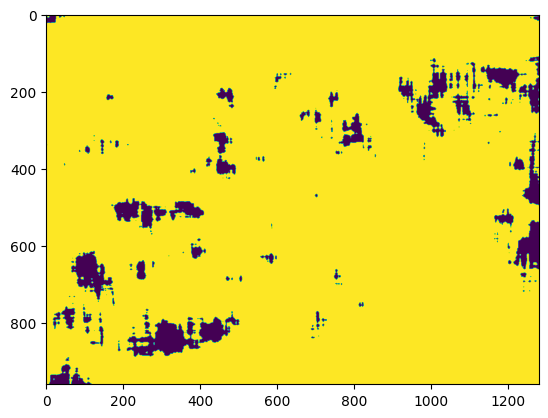

In [ ]:
def find_rough_areas(image, threshold=8):

    #read in image as greyscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #apply local binary pattern
    lbp = local_binary_pattern(image, P=8, R=2, method='uniform')

    lbp_uint8 = np.uint8((lbp / lbp.max())*255)
    
    blurred = cv2.blur(lbp_uint8, (5, 5), 0)
    mean = np.mean(blurred)
    std = np.std(blurred)
    median = np.median(blurred)
    #apply thresholding
    _, binary_image = cv2.threshold(blurred, mean - std, 255, cv2.THRESH_BINARY) 

    binary_blurred = cv2.blur(binary_image, (50, 50), 0)
    mean = np.mean(binary_blurred)
    std = np.std(binary_blurred)
    #apply thresholding
    _, binary_image = cv2.threshold(binary_blurred, mean - 1.5 * std, 255, cv2.THRESH_BINARY) # normlaize and convert to uint8, then blur
    plt.imshow(binary_image)
    print(binary_image)
    np.histogram(binary_image, bins=10, range=None, density=None, weights=None)
    
    #plt.imshow(binary_image)
    
    # Uncomment and adjust the contour finding and polygon processing as needed
    
    contours_outer, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #contours_tree, _ = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    #contours_ccomp, _ = cv2.findContours(binary_image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    polygons = []
    for contour in contours[0:-1]:
        points = []
        for point in contour:
            points.append(*point.tolist())
        polygons.append(points)

    return lbp, polygons

image_path = f"data/dacl10k_v2_devphase/images/train/dacl10k_v2_train_0001.jpg"
image = cv2.imread(image_path, cv2.IMREAD_COLOR)
dark_areas, dark_polygons = find_rough_areas(image)
#plot_picture_with_polygons(image, dark_polygons)
print(len(dark_polygons))